# Accurate Integer Mathematics in Transformers - Analyse the Model

This CoLab analyses a Transformer model that performs integer addition, subtraction and multiplication e.g. 133357+182243=+0315600, 123450-345670=-0123230 and 000345*000823=+283935. Each digit is a separate token. For 6 digit questions, the model is given 14 "question" (input) tokens, and must then predict the corresponding 8 "answer" (output) tokens.

## Tips for using the Colab
 * You can run and alter the code in this CoLab notebook yourself in Google CoLab ( https://colab.research.google.com/ ).
 * To run the notebook, in Google CoLab, **you will need to** go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.
 * Some graphs are interactive!
 * Use the table of contents pane in the sidebar to navigate.
 * Collapse irrelevant sections with the dropdown arrows.
 * Search the page using the search in the sidebar, not CTRL+F.

# Part 0A: Import libraries
Imports standard libraries. Don't bother reading.

In [1]:
DEVELOPMENT_MODE = True
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    !pip install matplotlib

    !pip install kaleido
    !pip install transformer_lens
    !pip install torchtyping
    !pip install transformers

    !pip install numpy
    !pip install scikit-learn

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.8 MB/s eta 

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import kaleido
import plotly.io as pio

if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [3]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [4]:
import json
import torch
import torch.nn.functional as F
import numpy as np
import random
import itertools
import re
from enum import Enum

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import textwrap

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


In [7]:
# Import Principal Component Analysis (PCA) library
use_pca = True
try:
  from sklearn.decomposition import PCA
except Exception as e:
  print("pca import failed with exception:", e)
  use_pca = False

  # Sometimes version conflicts means the PCA library does not import. This workaround partially fixes the issue
  !pip install --upgrade numpy
  !pip install --upgrade scikit-learn

  # To complete workaround, now select menu option "Runtime > Restart session and run all".
  stop

# Part 0C: Import verified_transformers library

Refer https://github.com/PhilipQuirke/verified_transformers/blob/main/README.md

In [8]:
!pip install --upgrade git+https://github.com/PhilipQuirke/verified_transformers.git
from QuantaTools import ( token_to_char, tokens_to_string, logits_to_tokens_loss, loss_fn,
  position_name, NodeLocation, UsefulNode, UsefulNodeList, str_to_node_location, answer_name )

from QuantaTools import ( QuantaFilter, QuantaType, NO_IMPACT_TAG,
  FilterNode, FilterAnd, FilterOr, FilterHead, FilterNeuron, FilterContains, FilterPosition, FilterAttention, FilterImpact, FilterPCA, FilterAlgo, filter_nodes,
  get_answer_impact, get_quanta_impact, calc_quanta_map, get_quanta_fail_perc, get_quanta_attention, get_quanta_binary, test_questions_and_add_node_attention_tags )

from QuantaTools import ( acfg, a_put_resid_post_hook, a_set_ablate_hooks, a_calc_mean_values, a_predict_questions, a_run_attention_intervention, search_and_tag )

from QuantaTools import ( MathsConfig, MathsTokens, MathsBehavior, MathsAlgorithm, set_maths_vocabulary, set_maths_question_meanings,
  int_to_answer_str, get_maths_min_complexity, maths_data_generator, maths_data_generator_core, make_maths_questions_and_answers,
  make_maths_test_questions_and_answers, test_maths_questions_by_complexity, test_maths_questions_by_impact, test_maths_questions_and_add_useful_node_tags,
  TRICASE_QUESTIONS, make_maths_tricase_questions )

  Cloning https://github.com/PhilipQuirke/verified_transformers.git to /tmp/pip-req-build-dyqt_hay
  Running command git clone --filter=blob:none --quiet https://github.com/PhilipQuirke/verified_transformers.git /tmp/pip-req-build-dyqt_hay
  Resolved https://github.com/PhilipQuirke/verified_transformers.git to commit 0889961298ef708eb40a7f9dbc3321cfbb1639f1
  Preparing metadata (setup.py) ... done
  Created wheel for QuantaTools: filename=QuantaTools-0.1-py3-none-any.whl size=37765 sha256=879a3259b825a97151914f4847cbea8f33427eb941aa66698a499bd8c4ec6942
  Stored in directory: /tmp/pip-ephem-wheel-cache-30g9chry/wheels/08/5c/b6/f02e46eb3b254e4572204214b92209ffbe2d0d4a5a61d3adb1
Successfully built QuantaTools


# Part 1A: Configuration: Detailed

In [9]:
# Main configuration class for main model creation and training.
# Derived from MathsConfig > UsefulConfig > ModelConfig
# Singleton class instance
cfg = MathsConfig()

# Part 1B: Configuration: Summary

Which existing model do we want to analyse?

The existing model weightings created by the sister Colab [VerifiedArithmeticTrain](https://github.com/PhilipQuirke/transformer-maths/blob/main/assets/VerifiedArithmeticTrain.ipynb) are loaded from HuggingFace.

In [10]:
# Which existing model do we want to analyse?
# cfg.model_name = "" # Use configuration specified in Part 1A
# cfg.model_name = "add_d5_l1_h3_t30K"  # 5 digit addition model. Inaccurate as only has one layer. Can predict S0, S1 and S2 complexity questions
# cfg.model_name = "add_d5_l2_h3_t15K"  # 5 digit addition model
cfg.model_name = "add_d6_l2_h3_t15K"  # 6 digit addition model
# cfg.model_name = "sub_d6_l2_h3_t30K"  # 6 digit subtraction model
# cfg.model_name = "mix_d6_l3_h4_t40K"  # 6 digit addition and subtraction model. AvgFinalLoss=8e-09
# cfg.model_name = "ins1_mix_d6_l3_h4_t40K"  # 6 digit addition / subtraction model. Initialise with addition model. Handles 1m Qs for Add and Sub
# cfg.model_name = "ins2_mix_d6_l4_h4_t40K"  # 6 digit addition / subtraction model. Initialised with addition model. Reset useful heads every 100 epochs. AvgFinalLoss=7e-09. Fails 1m Qs
# cfg.model_name = "ins3_mix_d6_l4_h3_t40K"  # 6 digit addition / subtraction model. Initialised with addition model. Reset useful heads & MLPs every 100 epochs. AvgFinalLoss=2.6e-06. Fails 1m Qs

# Part 1C: Configuration: Input and Output file names



In [11]:
if cfg.model_name != "":
  # Update cfg member data n_digits, n_layers, n_heads, n_training_steps from model_name
  cfg.parse_model_name()

  cfg.perc_sub = 0
  if cfg.model_name.startswith("sub_") :
    cfg.perc_sub = 100

  elif cfg.model_name == "mix_d6_l3_h4_t40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 66 # Train on 66% subtraction and 33% addition question batches

  elif cfg.model_name == "ins1_mix_d6_l3_h4_t40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    # Initialise with add_d6_l2_h3_t15K.pth.

  elif cfg.model_name == "ins2_mix_d6_l4_h4_t40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    # Initialise with add_d6_l2_h3_t15K.pth. Train & reset useful heads every 100 epochs

  elif cfg.model_name == "ins3_mix_d6_l4_h3_t40K" :
    cfg.batch_size = 256
    cfg.perc_sub = 80 # Train on 80% subtraction and 20% addition question batches
    # Initialise with add_d6_l2_h3_t15K.pth. Trained & reset useful heads & MLPs every 100 epochs

In [12]:
main_fname = cfg.file_config_prefix()
main_fname_pth = main_fname + '.pth'
main_fname_behavior_json = main_fname + '_behavior.json'
main_fname_algorithm_json = main_fname + '_algorithm.json'

def print_config():
  print("%Mult=", cfg.perc_mult, "%Sub=", cfg.perc_sub, "%Add=", cfg.perc_add(), "File", main_fname)

print_config()
print('Main model will be read from HuggingLab file', main_fname_pth)
print('Main model behavior analysis tags will save to Colab temporary file', main_fname_behavior_json)
print('Main model algorithm analysis tags will save to Colab temporary file', main_fname_algorithm_json)

%Mult= 0 %Sub= 0 %Add= 100 File add_d6_l2_h3_t15K_s372001
Main model will be read from HuggingLab file add_d6_l2_h3_t15K_s372001.pth
Main model behavior analysis tags will save to Colab temporary file add_d6_l2_h3_t15K_s372001_behavior.json
Main model algorithm analysis tags will save to Colab temporary file add_d6_l2_h3_t15K_s372001_algorithm.json


# Part 3A: Set Up: Vocabulary / Embedding / Unembedding

  

In [13]:
set_maths_vocabulary(cfg)
set_maths_question_meanings(cfg)
print(cfg.token_position_meanings)

['D5', 'D4', 'D3', 'D2', 'D1', 'D0', 'Op', "D'5", "D'4", "D'3", "D'2", "D'1", "D'0", '=', 'A7', 'A6', 'A5', 'A4', 'A3', 'A2', 'A1', 'A0']


# Part 3B: Set Up: Create model

In [14]:
# Transformer creation

# Structure is documented at https://neelnanda-io.github.io/TransformerLens/transformer_lens.html#transformer_lens.HookedTransformerConfig.HookedTransformerConfig
ht_cfg = HookedTransformerConfig(
    n_layers = cfg.n_layers,
    n_heads = cfg.n_heads,
    d_model = cfg.d_model,
    d_head = cfg.d_head,
    d_mlp = cfg.d_mlp(),
    act_fn = cfg.act_fn,
    normalization_type = 'LN',
    d_vocab = cfg.d_vocab,
    d_vocab_out = cfg.d_vocab,
    n_ctx = cfg.n_ctx(),
    init_weights = True,
    device = "cuda",
    seed = cfg.training_seed,
)

cfg.main_model = HookedTransformer(ht_cfg)

# Part 4: Set Up: Loss Function & Data Generator
This maths loss function and data generator are imported from QuantaTools as logits_to_tokens_loss, loss_fn, maths_data_generator_core and maths_data_generator.

In [15]:
# Define "iterator" maths "questions" data generator function. Invoked using next().
ds = maths_data_generator( cfg )

In [16]:
# Generate sample data generator (unit test)
print(next(ds)[:3,:])

tensor([[ 4,  9,  7,  0,  1,  8, 10,  5,  6,  2,  1,  0,  3, 12, 10,  8,  9,  4,
          0,  8,  7,  9],
        [ 9,  2,  8,  9,  9,  4, 10,  5,  5,  9,  6,  2,  1, 12, 10,  8,  5,  1,
          1,  3,  8,  5],
        [ 5,  8,  9,  8,  9,  3, 10,  8,  1,  1,  9,  9,  8, 12, 10,  8,  5,  9,
          8,  1,  0,  9]], device='cuda:0')


# Part 5: Set Up: Load Model from HuggingFace

In [17]:
main_repo_name="PhilipQuirke/VerifiedArithmetic"
print("Loading model from HuggingFace", main_repo_name, main_fname_pth)

cfg.main_model.load_state_dict(utils.download_file_from_hf(repo_name=main_repo_name, file_name=main_fname_pth, force_is_torch=True))
cfg.main_model.eval()

Loading model from HuggingFace PhilipQuirke/VerifiedArithmetic add_d6_l2_h3_t15K_s372001.pth


add_d6_l2_h3_t15K_s372001.pth:   0%|          | 0.00/25.2M [00:00<?, ?B/s]

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

# Part 7A: Set Up: Create sample maths questions

Create a batch of manually-curated mathematics test questions, and cache some sample model prediction outputs.

In [18]:
varied_questions = make_maths_test_questions_and_answers(cfg)

a_set_ablate_hooks(cfg)
a_calc_mean_values(cfg, varied_questions)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

# Part 7B: Results: Can the model correctly predict sample questions?

Ask the model to predict the varied_questions (without intervention) to see if the model gets them all right. Categorise answers by complexity

In [19]:
# Test maths question prediction accuracy on the sample questions provided.
# Does NOT use acfg.* or UsefulInfo.* information
# Used to estimate the accuracy of the model's predictions.
# Returns a reduced set of questions - removing questions that the model failed to answer.
varied_questions = test_maths_questions_by_complexity(cfg, acfg, varied_questions)

Group Math.Add.S2: Success Rate = 14.45% (25 good, 148 bad)
Group Math.Add.S1: Success Rate = 18.48% (39 good, 172 bad)
Group Math.Add.S4: Success Rate = 25.00% (8 good, 24 bad)
Group Math.Add.S3: Success Rate = 11.39% (9 good, 70 bad)
Group Math.Add.S0: Success Rate = 30.58% (37 good, 84 bad)
Group Math.Add.S5: Success Rate = 41.67% (10 good, 14 bad)
Varied_questions prediction success rate = 20.00% (128 good, 512 bad)
RESOLUTION: Understand these failures. Enrich the training data to provide more examples. Retrain the model.
INTERIM: Have reduced 'varied_questions' size from 640 to 128 so can continue.


# Part 9 : Results: Can the model do 1 million questions without error?

If the model passes this test, this is evidence (not proof) that the model is fully accurate. There may be very rare edge cases (say 1 in ten million) that did not appear in the test questions. Even if you believe you know all the edge cases, and have enriched the training data to contain them, you may not have thought of all edge cases, so this is not proof.

If the model fails this test:
- Add a few of the failures into the "test questions" in part 6C
- Understand the "use case(s)" driving these failures
- Alter the Training CoLab data_generator_core to enrich the training data with examples if these use case(s) and retrain the model.  

Takes ~25 mins to run (successfully) for ins_mix_d6_l3_h4_t40K_seed372001

In [20]:
def one_million_questions_core():
  global ds

  acfg.verbose = False

  cfg.analysis_seed = 345621 # Randomly chosen
  ds = maths_data_generator() # Re-initialise the data generator

  the_successes = 0
  the_fails = 0

  num_batches = 1000000//cfg.batch_size
  for epoch in range(num_batches):
      tokens = next(ds)

      the_fails = test_maths_questions_by_impact(cfg, acfg, tokens, 0, False)

      if the_fails> 0:
        break

      the_successes = the_successes + cfg.batch_size

      if epoch % 100 == 0:
          print("Batch", epoch, "of", num_batches, "#Successes=", the_successes)

  print("successes", the_successes, "num_fails", the_fails)
  if the_fails > 0:
    "WARNING: Model is not fully accurate. It failed the 1M Q test"

In [21]:
def one_million_questions():
  store_perc_sub = cfg.perc_sub
  store_perc_mult = cfg.perc_mult

  print_config()
  print()

  if cfg.perc_add() > 0:
    print("Addition:")
    cfg.perc_sub = 0
    cfg.perc_mult = 0
    one_million_questions_core()

  if store_perc_sub > 0:
    print("Subtraction:")
    cfg.perc_sub = 100
    cfg.perc_mult = 0
    one_million_questions_core()
    print()

  cfg.perc_sub = store_perc_sub
  cfg.perc_mult = store_perc_mult


# Takes ~25 minutes to run
# one_million_questions()

# Part 10: Set Up: Which token positions are used by the model?

Here we ablate all heads in each (question and answer) token position (overriding the model memory aka residual stream) and see if the model's prediction loss increases. If loss increases the token position is used by the algorithm. Unused token positions can be excluded from further analysis.

Used to calculate the UsefulInfo.useful_positions. This is (question and answer) **token-position level** information.  

In [22]:
num_failures_list = []
if cfg.n_digits >= 5 :

  num_questions = varied_questions.shape[0]

  for position in range(cfg.n_ctx()):
    # Test accuracy of model in predicting question answers. Ablates all nodes at acfg.ablate_position
    # Does NOT use UsefulInfo.* information. Used to populate UsefulInfo.useful_positions
    num_fails = test_maths_questions_by_impact(cfg, acfg, varied_questions, position, True)

    num_failures_list += [num_fails] if num_fails > 0 else "."

    if num_fails > 0:
      cfg.add_useful_position(position)

In [23]:
def save_plt_to_file( full_title ):
  if cfg.graph_file_suffix > "":
    filename = cfg.file_config_prefix() + full_title + '.' + cfg.graph_file_suffix
    filename = filename.replace(" ", "").replace(",", "").replace(":", "").replace("-", "")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

# Part 11: Results: Which token positions are used by the model?

Which token positions are is used in the model's predictions? Unused token positions can be excluded from further analysis.




%Mult= 0 %Sub= 0 %Add= 100 File add_d6_l2_h3_t15K_s372001
num_questions= 128
useful_positions= [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



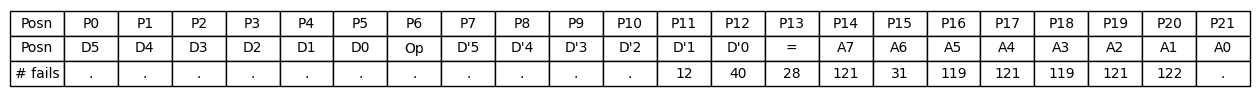

In [24]:
print_config()
print("num_questions=", num_questions)
print("useful_positions=", cfg.useful_positions )
print()

cfg.calc_position_failures_map(num_failures_list, 16)
save_plt_to_file("Failures When Position Ablated")
plt.show()

# Part 12A: Set Up: Which nodes are used by the model?

Here we ablate each (attention head and MLP neuron) node in each (question and answer) token position see if the model's prediction loss increases. If loss increases then the "node + token position" is used by the algorithm. Unused node+positions can be excluded from further analysis.

Used to calculate the UsefulInfo.useful_node_location. This is (question and answer) **node+position level** information.


In [25]:
def u_head_attn_hook_z(value, hook):
  # print( "In u_head_attn_hook_z", value.shape) # Get [1, 22, 3, 170] = ???, cfg.n_ctx, cfg.n_heads, cfg.d_head
  position = acfg.ablate_node_locations[0].position
  head = acfg.ablate_node_locations[0].num

  # Mean ablate. Copy the mean resid post values in position N to all the batch questions
  value[:,position,head,:] = acfg.mean_attn_z[:,position,head,:].clone()


# Ablating each head in each layer in each position and seeing if the loss increases shows which position+layer+head are used by the algorithm.
def u_head_perform_all(questions):
  for position in cfg.useful_positions:
    for layer in range(cfg.n_layers):
      for attn_head in range(cfg.n_heads):
        the_hook = [(acfg.l_attn_hook_z_name[layer], u_head_attn_hook_z)]
        # test accuracy of model in predicting question answers. Ablates at node-level. Adds node tags
        node_location = NodeLocation(position, layer, True, attn_head)
        #print( node_location.name())
        # Test accuracy of model in predicting question answers, when a single node is ablated.
        # Adds nodes to Useful.useful_nodes and adds tags to those nodes.
        test_maths_questions_and_add_useful_node_tags(cfg, acfg, node_location, questions, the_hook)
        #print( node_location.name(), cfg.useful_nodes.get_node(node_location).tags)

In [26]:
def u_mlp_hook_post(value, hook):
  # print( "In u_mlp_hook_post", value.shape) # Get [1099, 22, 2040] = num_questions, cfg.n_ctx, cfg.d_mlp (# neurons)
  position = acfg.ablate_node_locations[0].position

  # Mean ablate. Copy the mean resid post values in the MLP layer
  value[:,position,:] =  acfg.mean_mlp_hook_post[:,position,:].clone()
  #PQR When we do slices the MLP never fails?? Why??
  #slice_size = cfg.d_mlp // cfg.mlp_slices()
  #start_index = acfg.num * slice_size
  #end_index = start_index + slice_size
  #print ("PQR", cfg.mlp_slices(), slice_size, start_index, end_index)
  #value[:,acfg.ablate_position,start_index:end_index] = acfg.mean_mlp_hook_post[:,acfg.ablate_position,start_index:end_index].clone()


# Ablating the MLP in each layer in each position and seeing if the loss increases shows which layer+MLP are used by the algorithm.
def u_mlp_perform_all(questions):
  for position in cfg.useful_positions:
    for layer in range(cfg.n_layers):
      for num in range(cfg.mlp_slices()):
        the_hook = [(acfg.l_mlp_hook_post_name[layer], u_mlp_hook_post)]
        # test accuracy of model in predicting question answers. Ablates at node-level. Adds node tags
        node_location = NodeLocation(position, layer, False, num)
        #print( node_location.name())
        # Test accuracy of model in predicting question answers, when a single node is ablated.
        # Adds nodes to Useful.useful_nodes and adds tags to those nodes.
        test_maths_questions_and_add_useful_node_tags(cfg, acfg, node_location, questions, the_hook)
        #thenode = cfg.useful_nodes.get_node(node_location)
        #if thenode != None:
          #print( node_location.name(), thenode.tags)

In [27]:
acfg.verbose = False
cfg.useful_nodes = UsefulNodeList()
u_mlp_perform_all(varied_questions)
u_head_perform_all(varied_questions)
test_questions_and_add_node_attention_tags(cfg, varied_questions)
cfg.useful_nodes.sort_nodes()

# Part 12B: Results: Which nodes are used by the model?

Here are the (attention head and MLP neuron) node in each (question and answer) token position used by the model during predictions.

In [28]:
cfg.useful_nodes.print_node_tags()

P11L0M0 ['Fail%:7', 'Impact:A543', 'Math.Add:S234']
P11L0H0 ['Fail%:7', 'Impact:A4', 'Math.Add:S2', 'Attn:P3=54', 'Attn:P10=45']
P11L0H1 ['Fail%:9', 'Impact:A543', 'Math.Add:S234', 'Attn:P4=63', 'Attn:P11=32']
P12L0M0 ['Fail%:24', 'Impact:A54', 'Math.Add:S12345']
P12L0H0 ['Fail%:3', 'Impact:A4', 'Math.Add:S1', 'Attn:P2=51', 'Attn:P9=43']
P13L0M0 ['Fail%:21', 'Impact:A54321', 'Math.Add:S12345']
P13L0H1 ['Fail%:21', 'Impact:A54321', 'Math.Add:S12345', 'Attn:P5=69', 'Attn:P12=29']
P14L0M0 ['Fail%:4', 'Impact:A6', 'Math.Add:S1']
P14L0H0 ['Fail%:3', 'Impact:A6', 'Math.Add:S2', 'Attn:P1=52', 'Attn:P8=47']
P14L0H2 ['Fail%:17', 'Impact:A6', 'Math.Add:S145', 'Attn:P7=50', 'Attn:P0=50']
P15L0M0 ['Fail%:21', 'Impact:A5', 'Math.Add:S01245']
P15L0H0 ['Fail%:29', 'Impact:A5', 'Math.Add:S1234', 'Attn:P1=53', 'Attn:P8=45']
P15L0H1 ['Fail%:15', 'Impact:A5', 'Math.Add:S145', 'Attn:P7=35', 'Attn:P0=32', 'Attn:P15=24', 'Attn:P13=2']
P15L0H2 ['Fail%:92', 'Impact:A5', 'Math.Add:S012345', 'Attn:P0=46', 'Attn

 # Part 13: Set up: Show and save Quanta map

 Using the UsefulNodes and filtering their tags, show a 2D map of the nodes and the tag minor versions.

In [29]:
def show_quanta_map( title, standard_quanta, shades, filters : FilterNode, major_tag : str, minor_tag : str, get_node_details, base_fontsize = 10, max_width = 10 ):

  test_nodes = cfg.useful_nodes if filters == None else filter_nodes(cfg.useful_nodes, filters)

  ax1, quanta_results = calc_quanta_map(cfg, standard_quanta, shades, test_nodes, major_tag, minor_tag, get_node_details, base_fontsize, max_width )

  if cfg.graph_file_suffix > "":
    print("Saving quanta map:", title)
    save_plt_to_file(title)
  else:
    ax1.set_title(cfg.file_config_prefix() + ' ' + title + ' ({} nodes)'.format(len(quanta_results)))

  # Show plot
  plt.show()

# Part 16A: Results: Show failure percentage map

Show the percentage failure rate (incorrect prediction) when individual Attention Heads and MLPs are ablated.

A cell containing "< 1" may add some risk to the accuracy of the overall analysis process. Check to see if this represents a new use case. Improve the test data set to contain more instances of this (new or existing) use case.

Saving quanta map: Failure Frequency Behavior Per Node


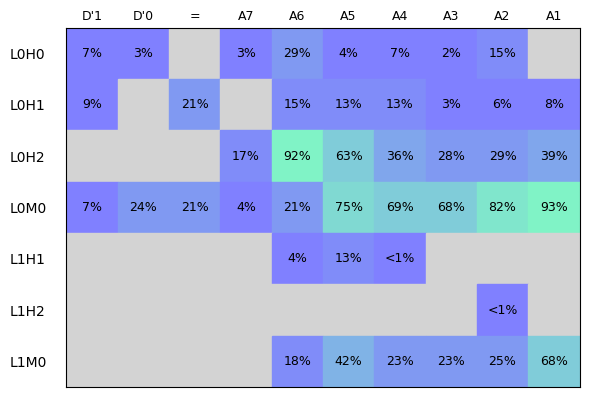

In [30]:
show_quanta_map( "Failure Frequency Behavior Per Node", True, 10, None, QuantaType.FAIL, "", get_quanta_fail_perc, 9)

# Part 16B - Show answer impact behavior map

Show the purpose of each useful cell by impact on the answer digits A0 to A5.


Saving quanta map: Answer Impact Behavior Per Node


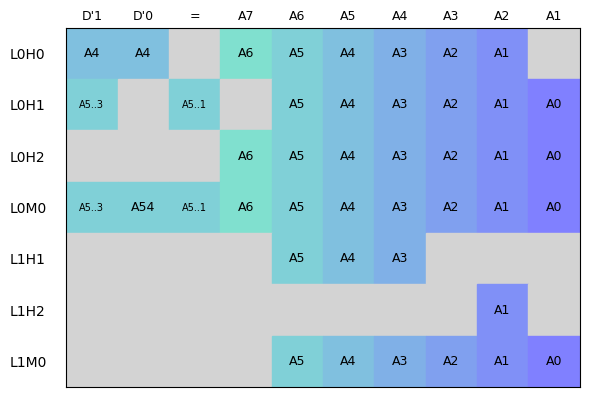

In [31]:
show_quanta_map( "Answer Impact Behavior Per Node", True, cfg.num_answer_positions, None, QuantaType.IMPACT, "", get_quanta_impact, 9, 6)

# Part 16C: Result: Show attention map

Show attention quanta of useful heads

Saving quanta map: Attention Behavior Per Head


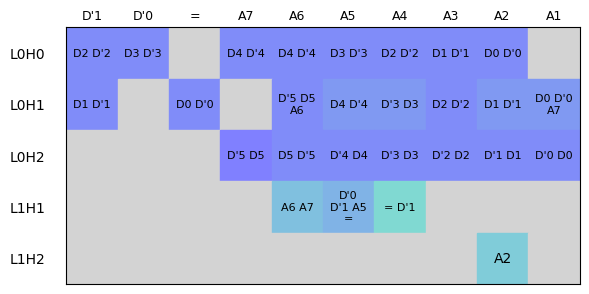

In [32]:
# Only maps attention heads, not MLP layers
show_quanta_map( "Attention Behavior Per Head", True, 10, None, QuantaType.ATTENTION, "", get_quanta_attention, 10, 6)

# Part 16C - Show question complexity map

Show the "minimum" addition purpose of each useful cell by S0 to S5 quanta.
Show the "minimum" subtraction purpose of each useful cell by M0 to M5 quanta

Saving quanta map: Addition Min-Complexity Behavior Per Node


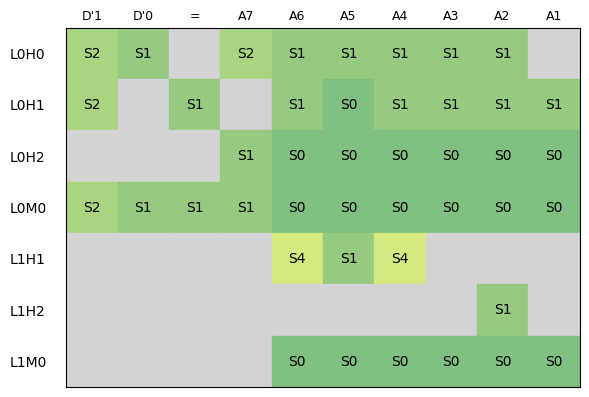

In [33]:
if cfg.perc_add() > 0:
  show_quanta_map( "Addition Min-Complexity Behavior Per Node", False, 6, None, QuantaType.MATH_ADD, "", get_maths_min_complexity)

In [34]:
if cfg.perc_sub > 0:
  show_quanta_map( "Subtraction Min-Complexity Behavior Per Node", False, 4, None, QuantaType.MATH_SUB, "", get_maths_min_complexity)

#Part 19A: Set Up: Calc and graph PCA decomposition.


In [35]:
# Create a cache of sample maths questions based on the T8, T9, T10 categorisation in cfg.tricase_questions_dict
make_maths_tricase_questions(cfg)

def pca_evr_0_percent(pca):
  return int(round(pca.explained_variance_ratio_[0]*100,0))

In [36]:
# Calculate one Principal Component Analysis
def calc_pca_for_an(node_location, operation, answer_digit):
  assert node_location.is_head == True

  try:
    t_questions = cfg.tricase_questions_dict[(answer_digit, operation)]

    _, the_cache = cfg.main_model.run_with_cache(t_questions)

    # Gather attention patterns for all the (randomly chosen) questions
    attention_outputs = []
    for i in range(len(t_questions)):

      # Output of individual heads, without final bias
      attention_cache=the_cache["result", node_location.layer, "attn"] # Output of individual heads, without final bias
      attention_output=attention_cache[i]  # Shape [n_ctx, n_head, d_model]
      attention_outputs.append(attention_output[node_location.position, node_location.num, :])

    attn_outputs = torch.stack(attention_outputs, dim=0).cpu()

    pca = PCA(n_components=6)
    pca.fit(attn_outputs)
    pca_attn_outputs = pca.transform(attn_outputs)

    title = node_location.name() + ', A'+str(answer_digit) + ', EVR[0]=' + str(pca_evr_0_percent(pca)) + '%'

    return pca, pca_attn_outputs, title
  except Exception as e:
    print( "calc_pca_for_an Failed:" + node_location.name() + " " + token_to_char(cfg, operation) + " " + answer_name(answer_digit), e)
    return None, None, None

In [37]:
# Plot the PCA of PnLnHn's attention pattern, using T8, T9, T10 questions that differ in the An digit
def plot_pca_for_an(ax, pca_attn_outputs, title):
  ax.scatter(pca_attn_outputs[:TRICASE_QUESTIONS, 0], pca_attn_outputs[:TRICASE_QUESTIONS, 1], color='red', label='T8 (0-8)') # t8 questions
  ax.scatter(pca_attn_outputs[TRICASE_QUESTIONS:2*TRICASE_QUESTIONS, 0], pca_attn_outputs[TRICASE_QUESTIONS:2*TRICASE_QUESTIONS, 1], color='green', label='T9') # t9 questions
  ax.scatter(pca_attn_outputs[2*TRICASE_QUESTIONS:, 0], pca_attn_outputs[2*TRICASE_QUESTIONS:, 1], color='blue', label='T10 (10-18)') # t10 questions
  if title != "" :
    ax.set_title(title)

In [38]:
def pca_op_tag(the_digit, operation, strong):
  return answer_name(the_digit)  + "." + (MathsBehavior.PCA_ADD_TAG if operation == MathsTokens.PLUS else MathsBehavior.PCA_SUB_TAG) + ( "" if strong else ".Weak")

In [39]:
def manual_node_pca(ax, position, layer, num, operation, answer_digit):

  node_location = NodeLocation(position, layer, True, num)
  pca, pca_attn_outputs, title = calc_pca_for_an(node_location, operation, answer_digit)
  plot_pca_for_an(ax, pca_attn_outputs, title)

  # Add the strong PCA tag to node PCA:A5.TR
  cfg.add_useful_node_tag( node_location, QuantaType.PCA, pca_op_tag(answer_digit, operation, True) )


def auto_node_pca(ax, index, node_location, operation, answer_digit, perc_threshold):

  pca, pca_attn_outputs, title = calc_pca_for_an(node_location, operation, answer_digit)
  if pca is not None:
    perc = pca_evr_0_percent(pca)
    if perc > perc_threshold:
      plot_pca_for_an(ax, pca_attn_outputs, title)

      # Add the weak PCA tag to node PCA:A5.TR.Weak
      cfg.add_useful_node_tag( node_location, QuantaType.PCA, pca_op_tag(answer_digit, operation, False) )
      return True

  return False

In [40]:
def manual_nodes_pca(op, nodes):
  print("Manual PCA tags for", cfg.model_name, "with operation", token_to_char(cfg, op))

  cols = 4
  rows = 1 + (len(nodes)+1) // cols

  fig, axs = plt.subplots(rows, cols)
  fig.set_figheight(rows*2 + 1)
  fig.set_figwidth(10)

  index = 0
  for node in nodes:
    manual_node_pca(axs[index // cols, index % cols], node[0], node[1], node[2], op, node[3])
    index += 1

  # Remove any graphs we dont need (except last one)
  while index < rows * cols - 1:
    ax = axs[index // cols, index % cols]
    ax.remove()
    index += 1

  # Replace last graph with the legend
  lines_labels = [axs[0,0].get_legend_handles_labels()]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  axs[rows-1, cols-1].legend(lines, labels)
  axs[rows-1, cols-1].axis('off') # Now, to hide the last subplot

  plt.tight_layout()
  save_plt_to_file('Pca Tr')
  plt.show()

#Part 19B: Results: Manual interpretation of PCA results

If an attention head and an answer digit An gives an interpretable response (2 or 3 distinct output clusters) on 3 groups of questions aligned to T8, T9 and T10 definitions, then plot the response and add a QuantaType.PCA tag



In [41]:
cfg.useful_nodes.reset_node_tags(QuantaType.PCA)

Manual PCA tags for add_d6_l2_h3_t15K with operation +


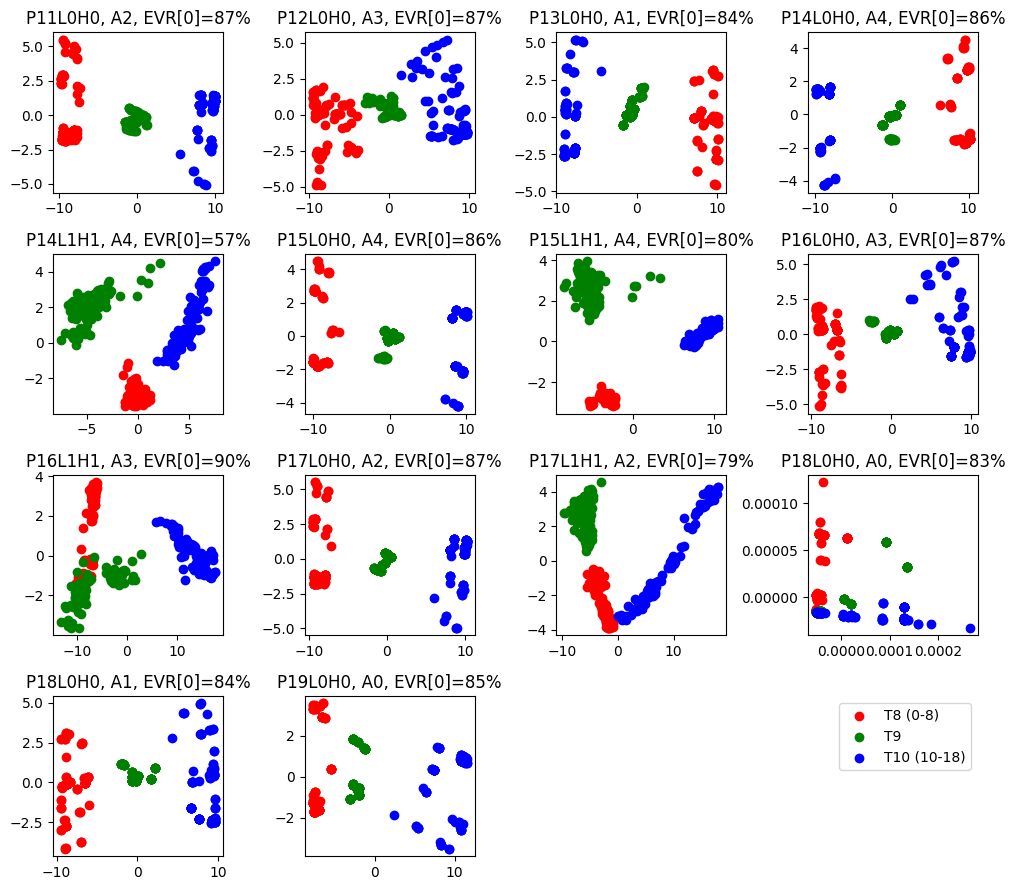

In [42]:
# Plot all attention heads with the clearest An selected
if use_pca:

  if cfg.model_name == "add_d5_l1_h3_t30K" :
    manual_nodes_pca(MathsTokens.PLUS,
      [[ 12, 0, 0, 4 ],
      [ 12, 0, 2, 3 ],
      [ 13, 0, 0, 3 ],
      [ 13, 0, 2, 2 ],
      [ 14, 0, 0, 2 ],
      [ 14, 0, 2, 1 ],
      [ 15, 0, 0, 1 ],
      [ 15, 0, 2, 0 ],
      [ 16, 0, 0, 0 ]])

  if cfg.model_name == "add_d5_l2_h3_t15K" :
    manual_nodes_pca(MathsTokens.PLUS,
      [[10, 0, 0, 2 ],
      [ 12, 0, 0, 3 ],
      [ 12, 1, 0, 3 ],
      [ 12, 1, 1, 4 ],
      [ 12, 1, 2, 4 ],
      [ 13, 0, 0, 0 ],
      [ 13, 0, 0, 3 ],
      [ 13, 1, 2, 2 ],
      [ 14, 0, 0, 0 ],
      [ 14, 0, 0, 2 ],
      [ 14, 1, 2, 2 ],
      [ 15, 0, 0, 1 ],
      [ 15, 0, 0, 0 ],
      [ 15, 1, 1, 1 ],
      [ 16, 0, 0, 0 ]])

  if cfg.model_name == "add_d6_l2_h3_t15K" :
    manual_nodes_pca(MathsTokens.PLUS,
      [[11, 0, 0, 2 ],
      [ 12, 0, 0, 3 ],
      [ 13, 0, 0, 1 ],
      [ 14, 0, 0, 4 ],
      [ 14, 1, 1, 4 ],
      [ 15, 0, 0, 4 ],
      [ 15, 1, 1, 4 ],
      [ 16, 0, 0, 3 ],
      [ 16, 1, 1, 3 ],
      [ 17, 0, 0, 2 ],
      [ 17, 1, 1, 2 ],
      [ 18, 0, 0, 0 ],
      [ 18, 0, 0, 1 ],
      [ 19, 0, 0, 0 ]])

  if cfg.model_name == "sub_d6_l2_h3_t30K" :
    manual_nodes_pca(MathsTokens.MINUS,
      [[14, 0, 1, 0 ],
      [ 15, 0, 0, 5 ],
      [ 15, 1, 1, 0 ],
      [ 15, 1, 1, 1 ],
      [ 15, 1, 1, 2 ],
      [ 15, 1, 1, 3 ],
      [ 15, 1, 1, 4 ],
      [ 15, 1, 2, 0 ],
      [ 15, 1, 2, 1 ],
      [ 15, 1, 2, 2 ],
      [ 15, 1, 2, 3 ],
      [ 16, 0, 0, 0 ],
      [ 16, 0, 0, 1 ],
      [ 16, 0, 0, 2 ],
      [ 16, 0, 0, 3 ],
      [ 16, 0, 0, 4 ],
      [ 16, 0, 0, 5 ],
      [ 16, 1, 0, 4 ],
      [ 16, 1, 1, 0 ],
      [ 16, 1, 1, 1 ],
      [ 16, 1, 1, 2 ],
      [ 16, 1, 1, 3 ],
      [ 16, 1, 1, 4 ],
      [ 16, 1, 2, 0 ],
      [ 16, 1, 2, 1 ],
      [ 16, 1, 2, 2 ],
      [ 16, 1, 2, 3 ],
      [ 16, 1, 2, 4 ],
      [ 16, 1, 2, 5 ],
      [ 17, 0, 0, 0 ],
      [ 17, 0, 0, 1 ],
      [ 17, 0, 0, 2 ],
      [ 17, 0, 0, 3 ],
      [ 17, 1, 0, 3 ],
      [ 17, 1, 0, 4 ],
      [ 17, 1, 2, 0 ],
      [ 17, 1, 2, 4 ],
      [ 18, 0, 0, 0 ],
      [ 18, 0, 0, 1 ],
      [ 18, 0, 0, 2 ],
      [ 18, 0, 2, 0 ],
      [ 18, 1, 2, 3 ],
      [ 19, 0, 0, 0 ],
      [ 19, 1, 2, 2 ],
      [ 20, 0, 0, 0 ],
      [ 18, 0, 2, 0 ],
	    [ 18, 0, 2, 0 ]])

  if cfg.model_name == "mix_d6_l3_h4_t40K" : # TBC
    manual_nodes_pca(MathsTokens.PLUS,
      [[ 8, 0, 0, 4 ],
      [  9, 0, 1, 3 ],
      [ 10, 0, 1, 2 ],
      [ 10, 0, 1, 3 ],
      [ 11, 0, 1, 1 ],
      [ 11, 0, 1, 2 ],
      [ 12, 0, 0, 0 ],
      [ 13, 0, 1, 4 ],
      [ 13, 1, 1, 0 ],
      [ 13, 1, 1, 1 ],
      [ 13, 1, 1, 2 ],
      [ 13, 1, 1, 3 ],
      [ 13, 1, 2, 3 ],
      [ 13, 1, 2, 5 ],
      [ 14, 0, 1, 0 ],
      [ 15, 0, 0, 0 ],
      [ 15, 0, 0, 1 ],
      [ 15, 0, 0, 2 ],
      [ 15, 0, 0, 3 ],
      [ 15, 0, 0, 4 ],
      [ 15, 0, 0, 5 ],
      [ 15, 1, 0, 0 ],
      [ 15, 1, 0, 1 ],
      [ 15, 1, 0, 2 ],
      [ 15, 1, 0, 3 ],
      [ 15, 1, 0, 4 ]])

  if cfg.model_name == "ins1_mix_d6_l3_h4_t40K" :
    manual_nodes_pca(MathsTokens.PLUS,
      [[13, 1, 3, 1 ],
      [ 14, 1, 2, 0 ],
      [ 14, 1, 2, 2 ],
      [ 14, 1, 3, 4 ],
      [ 15, 0, 3, 5 ],
      [ 15, 1, 2, 2 ],
      [ 15, 1, 3, 4 ],
      [ 16, 0, 3, 4 ],
      [ 16, 1, 2, 0 ],
      [ 16, 1, 2, 1 ],
      [ 16, 1, 2, 2 ],
      [ 16, 1, 3, 2 ],
      [ 17, 0, 3, 3 ],
      [ 17, 1, 2, 2 ],
      [ 17, 1, 3, 2 ],
      [ 18, 0, 3, 2 ],
      [ 18, 1, 3, 1 ],
      [ 19, 0, 3, 1 ],
      [ 19, 2, 0, 0 ],
      [ 19, 2, 1, 0 ],
      [ 20, 0, 0, 0 ],
      [ 20, 0, 3, 0 ]])

else:
  print( "PCA library failed to import. So PCA not done")

#Part 19C: Results: Automatic interpetation of PCA results

Part 19B is manual and selective. This part is automatic. It tests nodes not included in Part 19B, where this first (single) principal component explains 66% or more of the node. It adds a QuantaType.PCA "weak" tag

In [43]:
def auto_find_pca_node(node, op, perc_threshold):
  fig, axs = plt.subplots(2, 4) # Allow up to 8 graphs
  fig.set_figheight(4)
  fig.set_figwidth(10)

  index = 0
  for answer_digit in range(cfg.n_digits+1):
    ax = axs[index // 4, index % 4]
    if auto_node_pca(ax, index, node, op, answer_digit, perc_threshold):
      index += 1

  # Remove any graphs we dont need after all
  while index < 2 * 4:
    ax = axs[index // 4, index % 4]
    ax.remove()
    index += 1

  plt.tight_layout()
  plt.show()

Automatic (weak) PCA tags for add_d6_l2_h3_t15K with operation +
Doing PCA on node P11L0H1
calc_pca_for_an Failed:P11L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P13L0H1
calc_pca_for_an Failed:P13L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P14L0H2
calc_pca_for_an Failed:P14L0H2 + A6 (6, 10)


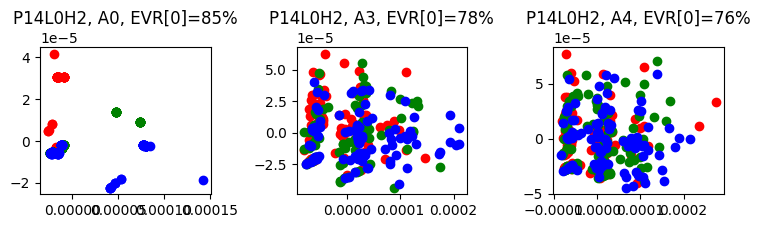

Doing PCA on node P15L0H1
calc_pca_for_an Failed:P15L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P15L0H2
calc_pca_for_an Failed:P15L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P16L0H1
calc_pca_for_an Failed:P16L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P16L0H2
calc_pca_for_an Failed:P16L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P17L0H1
calc_pca_for_an Failed:P17L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P17L0H2
calc_pca_for_an Failed:P17L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P18L0H1
calc_pca_for_an Failed:P18L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P18L0H2
calc_pca_for_an Failed:P18L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P19L0H1
calc_pca_for_an Failed:P19L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P19L0H2
calc_pca_for_an Failed:P19L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P19L1H2
calc_pca_for_an Failed:P19L1H2 + A6 (6, 10)


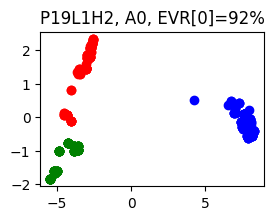

Doing PCA on node P20L0H1
calc_pca_for_an Failed:P20L0H1 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

Doing PCA on node P20L0H2
calc_pca_for_an Failed:P20L0H2 + A6 (6, 10)


<Figure size 1000x400 with 0 Axes>

In [44]:
def auto_find_pca(op):
  print("Automatic (weak) PCA tags for", cfg.model_name, "with operation", token_to_char(cfg, op))
  perc_threshold = 75

  for node in cfg.useful_nodes.nodes:

    # Exclude nodes with a (manual) PCA tag - for any answer digit(s)). Exclude MLP neurons.
    minor_tag_prefix = MathsBehavior.PCA_ADD_TAG if op == MathsTokens.PLUS else MathsBehavior.PCA_SUB_TAG
    if node.is_head and not node.contains_tag(QuantaType.PCA, minor_tag_prefix):
      print( "Doing PCA on node", node.name())

      auto_find_pca_node(node, op, perc_threshold)


if use_pca:
  if cfg.perc_add() > 0:
    auto_find_pca(MathsTokens.PLUS)
  if cfg.perc_sub > 0:
    auto_find_pca(MathsTokens.MINUS)

# Part 20A: Results: Show useful nodes and behaviour tags

In [45]:
cfg.useful_nodes.sort_nodes()
cfg.useful_nodes.print_node_tags()

P11L0M0 ['Fail%:7', 'Impact:A543', 'Math.Add:S234']
P11L0H0 ['Fail%:7', 'Impact:A4', 'Math.Add:S2', 'Attn:P3=54', 'Attn:P10=45', 'PCA:A2.PA']
P11L0H1 ['Fail%:9', 'Impact:A543', 'Math.Add:S234', 'Attn:P4=63', 'Attn:P11=32']
P12L0M0 ['Fail%:24', 'Impact:A54', 'Math.Add:S12345']
P12L0H0 ['Fail%:3', 'Impact:A4', 'Math.Add:S1', 'Attn:P2=51', 'Attn:P9=43', 'PCA:A3.PA']
P13L0M0 ['Fail%:21', 'Impact:A54321', 'Math.Add:S12345']
P13L0H0 ['PCA:A1.PA']
P13L0H1 ['Fail%:21', 'Impact:A54321', 'Math.Add:S12345', 'Attn:P5=69', 'Attn:P12=29']
P14L0M0 ['Fail%:4', 'Impact:A6', 'Math.Add:S1']
P14L0H0 ['Fail%:3', 'Impact:A6', 'Math.Add:S2', 'Attn:P1=52', 'Attn:P8=47', 'PCA:A4.PA']
P14L0H2 ['Fail%:17', 'Impact:A6', 'Math.Add:S145', 'Attn:P7=50', 'Attn:P0=50', 'PCA:A0.PA.Weak', 'PCA:A3.PA.Weak', 'PCA:A4.PA.Weak']
P14L1H1 ['PCA:A4.PA']
P15L0M0 ['Fail%:21', 'Impact:A5', 'Math.Add:S01245']
P15L0H0 ['Fail%:29', 'Impact:A5', 'Math.Add:S1234', 'Attn:P1=53', 'Attn:P8=45', 'PCA:A4.PA']
P15L0H1 ['Fail%:15', 'Impact:A5

# Part 20B: Results: Save useful nodes and behaviour tags to json file

In [46]:
# Serialize and save the useful nodes list to a temporary CoLab file in JSON format
print( "Saving useful node list with behavior tags:", main_fname_behavior_json)
cfg.useful_nodes.save_nodes(main_fname_behavior_json)

Saving useful node list with behavior tags: add_d6_l2_h3_t15K_s372001_behavior.json


# Part 21A : Set up: Interchange Interventions

Here we prove that model nodes perform specified calculations. If all the calculations in an algorithm hypothesis are found to exist in a model instance, this provides evidence for the hypothesis.   

**Automatic searches** for node purposes are preferred, as they applicable to several models, and survive (non-sigificant, node-reordering) changes to the model after training. When a node purpose is detected, this is documented as a tag on the node.

**Manually written tests** of node purposes, specific to a single model instance are also supported.

In [101]:
def run_intervention_core(node_locations, store_question, clean_question, operation, expected_answer_impact, expected_answer_int, strong):
  assert(len(node_locations) > 0)
  assert(store_question[0] < + 10 ** cfg.n_digits)
  assert(store_question[1] > - 10 ** cfg.n_digits)
  assert(store_question[0] < + 10 ** cfg.n_digits)
  assert(store_question[1] > - 10 ** cfg.n_digits)
  assert(clean_question[0] < + 10 ** cfg.n_digits)
  assert(clean_question[1] > - 10 ** cfg.n_digits)
  assert(clean_question[0] < + 10 ** cfg.n_digits)
  assert(clean_question[1] > - 10 ** cfg.n_digits)

  # Calculate the test (clean) question answer e.g. "+006671"
  clean_answer_int = clean_question[0]+clean_question[1] if operation == MathsTokens.PLUS else clean_question[0]-clean_question[1]
  clean_answer_str = int_to_answer_str(cfg, clean_answer_int)
  expected_answer_str = int_to_answer_str(cfg, expected_answer_int)

  # Matrices of tokens
  store_question_and_answer = make_maths_questions_and_answers(cfg, acfg.operation, "", "", [store_question])
  clean_question_and_answer = make_maths_questions_and_answers(cfg, acfg.operation, "", "", [clean_question])

  acfg.reset_intervention(expected_answer_str, expected_answer_impact, operation)
  acfg.ablate_node_locations = node_locations

  run_description = a_run_attention_intervention(cfg, store_question_and_answer, clean_question_and_answer, clean_answer_str)

  return "Intervening on " + acfg.node_names() + ", " + ("Strong" if strong else "Weak") + ", Node[0]=" + acfg.ablate_node_locations[0].name() + ", " + run_description


# Run an intervention where we have a precise expectation of the intervention impact
def run_strong_intervention(node_locations, store_question, clean_question, operation, expected_answer_impact, expected_answer_int):

  # These are the actual model prediction outputs (while applying our node-level intervention).
  description = run_intervention_core(node_locations, store_question, clean_question, operation, expected_answer_impact, expected_answer_int, True)

  answer_success = (acfg.intervened_answer == acfg.expected_answer)
  impact_success = (acfg.intervened_impact == acfg.expected_impact)
  success = answer_success and impact_success

  if acfg.show_test_failures and not success:
    print("Failed: " + description)

  return success, answer_success, impact_success


# Run an intervention where we expect the intervention to have a non-zero impact and we cant precisely predict the answer
def run_weak_intervention(node_locations, store_question, clean_question, operation):

  # Calculate the test (clean) question answer e.g. "+006671"
  expected_answer_int = clean_question[0]+clean_question[1] if operation == MathsTokens.PLUS else clean_question[0]-clean_question[1]

  description = run_intervention_core(node_locations, store_question, clean_question, operation, NO_IMPACT_TAG, expected_answer_int, False)

  success = not ((acfg.intervened_answer == acfg.expected_answer) or (acfg.intervened_impact == NO_IMPACT_TAG))

  if acfg.show_test_failures and not success:
    print("Failed: Intervention had no impact on the answer", description)

  return success

In [102]:
def repeat_digit(digit):
    return int(str(digit) * cfg.n_digits)


# unit test
if cfg.n_digits == 6:
  assert repeat_digit(4) == 444444

In [103]:
def succeed_test(node_locations, alter_digit, strong):
  print( "Test confirmed", node_locations[0].name(), node_locations[1].name() if len(node_locations)>1 else "", "" if strong else "Weak")
  return True

In [104]:
cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)

# Part 21B: Automated An.US search

The addition Use Sum 9 (US) operation is a simple task. Search for An.US tasks.

In [105]:
def add_us_tag(impact_digit):
  return answer_name(impact_digit-1)  + "." + MathsAlgorithm.ADD_US_TAG

In [106]:
# These rules are prerequisites for (not proof of) an Addition UseSum9 node
def add_us_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(impact_digit-2)), # Attends to Dn-2
    FilterAttention(cfg.ddn_to_position_name(impact_digit-2)), # Attends to D'n-2
    FilterImpact(answer_name(impact_digit)))

In [107]:
def add_us_test(node_locations, alter_digit, strong):
  if alter_digit < 2 or alter_digit > cfg.n_digits:
    acfg.reset_intervention()
    return False

  intervention_impact = answer_name(alter_digit)

  # 25222 + 44444 = 69666. Has no Dn-2.MC but has Dn-1.US so not a US case
  store_question = [repeat_digit(2), repeat_digit(4)]
  store_question[0] += (5-2) * 10 ** (alter_digit - 1)

  # 34633 + 55555 = 90188. Has Dn-2.MC and Dn-1.US so is a US case
  clean_question = [repeat_digit(3), repeat_digit(5)]
  clean_question[0] += (4-3) * 10 ** (alter_digit - 1)
  clean_question[0] += (6-3) * 10 ** (alter_digit - 2)

  # When we intervene we expect answer 80188
  intervened_answer = clean_question[0] + clean_question[1] - 10 ** (alter_digit)


  # Unit test
  if cfg.n_digits == 5 and alter_digit == 4:
    assert store_question[0] == 25222
    assert clean_question[0] == 34633
    assert clean_question[0] + clean_question[1] == 90188
    assert intervened_answer == 80188


  success, _, _ = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.PLUS, intervention_impact, intervened_answer)

  if success:
    print( "Test confirmed", acfg.node_names(), "perform D"+str(alter_digit)+".US impacting "+intervention_impact+" accuracy.", "" if strong else "Weak")

  return success

In [108]:
search_and_tag( cfg, acfg, add_us_prereqs, add_us_test, add_us_tag, False, False)

Test confirmed P11L0H0 perform D4.US impacting A4 accuracy. 
Test confirmed P14L0H0 perform D6.US impacting A6 accuracy. 
Ran 2 intervention test(s). Added 2 tag(s)


# Part 21C: Automated An.MC search

The addition Make Carry (MC) operation is a simple task. Search for An.MC tasks.

In [109]:
def add_mc_tag(impact_digit):
  return answer_name(impact_digit-1)  + "." + MathsAlgorithm.ADD_MC_TAG

In [110]:
# These rules are prerequisites for (not proof of) an Addition MakeCarry node
def add_mc_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(impact_digit-1)), # MC is calculated on the next lower-value digit.
    FilterAttention(cfg.ddn_to_position_name(impact_digit-1)), # MC is calculated on the next lower-value digit.
    FilterImpact(answer_name(impact_digit)))

In [111]:
def add_mc_test(node_locations, impact_digit, strong):
  alter_digit = impact_digit - 1

  if alter_digit < 0 or alter_digit >= cfg.n_digits:
    acfg.reset_intervention()
    return False

  intervention_impact = answer_name(impact_digit)

  # 222222 + 666966 = 889188. Has Dn.MC
  store_question = [repeat_digit(2), repeat_digit(6)]
  store_question[1] += (9 - 6) * (10 ** alter_digit)

  # 333333 + 555555 = 888888. No Dn.MC
  clean_question = [repeat_digit(3), repeat_digit(5)]

  # When we intervene we expect answer 889888
  intervened_answer = clean_question[0] + clean_question[1] + 10 ** (alter_digit+1)

  success, _, _ = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.PLUS, intervention_impact, intervened_answer)

  if success:
    print( "Test confirmed", acfg.node_names(), "perform D"+str(alter_digit)+".MC impacting "+intervention_impact+" accuracy.", "" if strong else "Weak")

  return success

In [112]:
search_and_tag( cfg, acfg, add_mc_prereqs, add_mc_test, add_mc_tag, False, False)

Test confirmed P19L0H0 perform D0.MC impacting A1 accuracy. 
Test confirmed P18L0H0 perform D1.MC impacting A2 accuracy. 
Test confirmed P17L0H0 perform D2.MC impacting A3 accuracy. 
Failed: Intervening on P12L0H0, Strong, Node[0]=P12L0H0, CleanAnswer: +0888888, ExpectedAnswer/Impact: +0898888/A4, IntervenedAnswer/Impact: +0888888/(none)
Test confirmed P16L0H0 perform D3.MC impacting A4 accuracy. 
Test confirmed P15L0H0 perform D4.MC impacting A5 accuracy. 
Test confirmed P14L0H2 perform D5.MC impacting A6 accuracy. 
Ran 7 intervention test(s). Added 6 tag(s)


# Part 21D: Automated An.BA search

The addition Base Add (BA) operation is a simple task. The task may be split/shared over 2 attention heads in the same position. Search for An.BA calculations.

In [113]:
def add_ba_tag(impact_digit):
  return answer_name(impact_digit) + "." + MathsAlgorithm.ADD_BA_TAG

In [114]:
# These rules are prerequisites for (not proof of) an Addition BaseAdd node
def add_ba_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(impact_digit)), # Attends to Dn
    FilterAttention(cfg.ddn_to_position_name(impact_digit)), # Attends to D'n
    FilterImpact(answer_name(impact_digit)), # Impacts An
    FilterAlgo(add_ba_tag(impact_digit), QuantaFilter.NOT)) # Has not already been flagged as a BA task

In [115]:
def add_ba_test1(alter_digit):
  # 222222 + 111111 = 333333. No Dn.MC
  store_question = [repeat_digit(2), repeat_digit(1)]

  # 555555 + 444444 = 999999. No Dn.MC
  clean_question = [repeat_digit(5), repeat_digit(4)]

  # When we intervene we expect answer 999399
  intervened_answer = clean_question[0] + clean_question[1] + (3-9) * 10 ** alter_digit

  return store_question, clean_question, intervened_answer


def add_ba_test2(alter_digit):
  # 222222 + 666666 = 888888. No Dn.MC
  store_question = [repeat_digit(2), repeat_digit(6)]

  # 555555 + 111111 = 666666. No Dn.MC
  clean_question = [repeat_digit(5), repeat_digit(1)]

  # When we intervene we expect answer 666866
  intervened_answer = clean_question[0] + clean_question[1] + (8-6) * 10 ** alter_digit

  return store_question, clean_question, intervened_answer


def add_ba_test(node_locations, alter_digit, strong):
  intervention_impact = answer_name(alter_digit)

  store_question, clean_question, intervened_answer = add_ba_test1(alter_digit)
  success1, answer_success1, impact_success1 = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.PLUS, intervention_impact, intervened_answer)

  store_question, clean_question, intervened_answer = add_ba_test2(alter_digit)
  success2, answer_success2, impact_success2 = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.PLUS, intervention_impact, intervened_answer)

  success = (success1 and success2) if strong else (impact_success1 and impact_success2)

  if success:
    print( "Test confirmed:", acfg.node_names(), "perform D"+str(alter_digit)+".BA = (D"+str(alter_digit)+" + D'"+str(alter_digit)+") % 10 impacting "+intervention_impact+" accuracy.", "" if strong else "Weak", acfg.intervened_answer)

  return success

In [116]:
#cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)
#acfg.show_test_failures = True
search_and_tag( cfg, acfg, add_ba_prereqs, add_ba_test, add_ba_tag, True, True )

Failed: Intervening on P20L0H1, Strong, Node[0]=P20L0H1, CleanAnswer: +0999999, ExpectedAnswer/Impact: +0999993/A0, IntervenedAnswer/Impact: +0999999/(none)
Failed: Intervening on P20L0H1, Strong, Node[0]=P20L0H1, CleanAnswer: +0666666, ExpectedAnswer/Impact: +0666668/A0, IntervenedAnswer/Impact: +0666667/A0, Loss: 0.5989681477802504
Failed: Intervening on P20L0H2, Strong, Node[0]=P20L0H2, CleanAnswer: +0999999, ExpectedAnswer/Impact: +0999993/A0, IntervenedAnswer/Impact: +0999996/A0, Loss: 1.160719600862343
Failed: Intervening on P20L0H2, Strong, Node[0]=P20L0H2, CleanAnswer: +0666666, ExpectedAnswer/Impact: +0666668/A0, IntervenedAnswer/Impact: +0666667/A0, Loss: 2.0831675525459787
Test confirmed: P20L0H1, P20L0H2 perform D0.BA = (D0 + D'0) % 10 impacting A0 accuracy.  +0666668
Failed: Intervening on P19L0H1, Strong, Node[0]=P19L0H1, CleanAnswer: +0999999, ExpectedAnswer/Impact: +0999939/A1, IntervenedAnswer/Impact: +0999999/(none)
Failed: Intervening on P19L0H1, Strong, Node[0]=P19L

# Part 21E: Automated Dn.C search

Search for D0.C to D5.C with impact "A65432" to "A65" in early tokens.

A0 and A1 are too simple to need Dn.C values so they are excluded from the answer impact.

In [117]:
def add_tc_tag(focus_digit):
  return "D" + str(focus_digit) + "." + MathsAlgorithm.ADD_TC_TAG

In [118]:
# These rules are prerequisites for (not proof of) an Addition Dn.C node
def add_tc_prereqs(position, focus_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(focus_digit)), # Attends to Dn
    FilterAttention(cfg.ddn_to_position_name(focus_digit)), # Attends to D'n
    FilterPCA(MathsBehavior.PCA_ADD_TAG, QuantaFilter.CONTAINS)) # Node PCA is interpretable (bigram or trigram output) with respect to T8,T9,T10

In [119]:
def add_tc_test(node_locations, focus_digit, strong):
  # 222222 + 777977 = 1000188. Has Dn.MC
  store_question = [repeat_digit(2), repeat_digit(7)]
  store_question[1] += (9 - 7) * (10 ** focus_digit)

  # 333333 + 666666 = 999999. No Dn.MC
  clean_question = [repeat_digit(3), repeat_digit(6)]

  success = run_weak_intervention(node_locations, store_question, clean_question, MathsTokens.PLUS)

  if success:
    description = acfg.node_names() + " perform D"+str(focus_digit)+".C = TriCase(D"+str(focus_digit)+" + D'"+str(focus_digit)+")"
    print("Test confirmed", description, "Impact:", acfg.intervened_impact, "" if strong else "Weak")

  return success

In [120]:
if cfg.n_layers > 1: # Have not seen this task in 1-layer models.
  search_and_tag( cfg, acfg, add_tc_prereqs, add_tc_test, add_tc_tag,
    False, # Have not seen this task split between nodes.
    False,
    cfg.n_digits, cfg.num_question_positions) # These occur from the first D'n digit to the first answer digit.

Test confirmed P11L0H0 perform D2.C = TriCase(D2 + D'2) Impact: A6543 
Test confirmed P12L0H0 perform D3.C = TriCase(D3 + D'3) Impact: A654 
Test confirmed P14L0H0 perform D4.C = TriCase(D4 + D'4) Impact: A6 
Test confirmed P14L0H2 perform D5.C = TriCase(D5 + D'5) Impact: A6 
Ran 4 intervention test(s). Added 4 tag(s)


# Part 21F: Automated An.BS search

The subtraction Base Subtraction (BS) operation is a simple task. The task may be split/shared over 2 attention heads in the same position. Search for An.BS calculations.

In [121]:
def sub_bs_tag(impact_digit):
  return answer_name(impact_digit) + "." + MathsAlgorithm.SUB_BS_TAG

In [122]:
# These rules are prerequisites for (not proof of) a BaseSubtraction node
def sub_bs_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(impact_digit)), # Attends to Dn
    FilterAttention(cfg.ddn_to_position_name(impact_digit)), # Attends to D'n
    FilterImpact(answer_name(impact_digit)), # Impacts An
    FilterAlgo(sub_bs_tag(impact_digit), QuantaFilter.NOT)) # Has not already been flagged as a BS task

In [123]:
def sub_bs_test1(alter_digit):
  # 333333 - 111111 = 222222. No Dn.BO
  store_question = [repeat_digit(3), repeat_digit(1)]

  # 999999 - 444444 = 555555. No Dn.BO
  clean_question = [repeat_digit(9), repeat_digit(4)]

  # When we intervene we expect answer 555255
  intervened_answer = clean_question[0] - clean_question[1] + (2-5) * 10 ** alter_digit

  return store_question, clean_question, intervened_answer


def sub_bs_test2(alter_digit):
  # 666666 - 222222 = 444444. No Dn.BO
  store_question = [repeat_digit(6), repeat_digit(2)]

  # 999999 - 333333 = 666666. No Dn.BO
  clean_question = [repeat_digit(9), repeat_digit(3)]

  # When we intervene we expect answer 666466
  intervened_answer = clean_question[0] - clean_question[1] + (4-6) * 10 ** alter_digit

  return store_question, clean_question, intervened_answer


def sub_bs_test(node_locations, alter_digit, strong):
  intervention_impact = answer_name(alter_digit)

  store_question, clean_question, intervened_answer = sub_bs_test1(alter_digit)
  success1, answer_success1, impact_success1 = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.MINUS, intervention_impact, intervened_answer)

  store_question, clean_question, intervened_answer = sub_bs_test2(alter_digit)
  success2, answer_success2, impact_success2 = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.MINUS, intervention_impact, intervened_answer)

  success = (success1 and success2) if strong else (impact_success1 and impact_success2)

  if success:
    print( "Test confirmed:", acfg.node_names(), "perform D"+str(alter_digit)+".BS = (D"+str(alter_digit)+" + D'"+str(alter_digit)+") % 10 impacting "+intervention_impact+" accuracy.", "" if strong else "Weak")

  return success

In [124]:
#cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)
#acfg.show_test_failures = True
search_and_tag( cfg, acfg, sub_bs_prereqs, sub_bs_test, sub_bs_tag, True, True, cfg.num_question_positions )

Failed: Intervening on P20L0H1, Strong, Node[0]=P20L0H1, CleanAnswer: +0555555, ExpectedAnswer/Impact: +0555552/A0, IntervenedAnswer/Impact: +1444443/A6543210
Failed: Intervening on P20L0H1, Strong, Node[0]=P20L0H1, CleanAnswer: +0666666, ExpectedAnswer/Impact: +0666664/A0, IntervenedAnswer/Impact: +1333335/A6543210, Loss: 18.65778601356228
Failed: Intervening on P20L0H2, Strong, Node[0]=P20L0H2, CleanAnswer: +0555555, ExpectedAnswer/Impact: +0555552/A0, IntervenedAnswer/Impact: +1444444/A6543210, Loss: 16.372420332970115
Failed: Intervening on P20L0H2, Strong, Node[0]=P20L0H2, CleanAnswer: +0666666, ExpectedAnswer/Impact: +0666664/A0, IntervenedAnswer/Impact: +1333339/A6543210, Loss: 18.553112483623494
Failed: Intervening on P20L0H1, P20L0H2, Strong, Node[0]=P20L0H1, CleanAnswer: +0555555, ExpectedAnswer/Impact: +0555552/A0, IntervenedAnswer/Impact: +1444444/A6543210, Loss: 18.38104514378692
Failed: Intervening on P20L0H1, P20L0H2, Strong, Node[0]=P20L0H1, CleanAnswer: +0666666, Expec

# Part 21G: Automated An.BO search

The subtraction Borrow One operation is a simple task. Search for An.BO tasks.

In [125]:
def sub_bo_tag(impact_digit):
  return answer_name(impact_digit-1)  + "." + MathsAlgorithm.SUB_BO_TAG

In [126]:
# These rules are prerequisites for (not proof of) an subtraction Borrow One node
def sub_bo_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.dn_to_position_name(impact_digit-1)), # BO is calculated on the next lower-value digit.
    FilterAttention(cfg.ddn_to_position_name(impact_digit-1)), # BO is calculated on the next lower-value digit.
    FilterImpact(answer_name(impact_digit)))

In [127]:
def sub_bo_test(node_locations, impact_digit, strong):
  alter_digit = impact_digit - 1

  if alter_digit < 0 or alter_digit >= cfg.n_digits:
    acfg.reset_intervention()
    return False

  intervention_impact = answer_name(impact_digit)

  # 222222 - 111311 = 110911. Has Dn.BO
  store_question = [repeat_digit(2), repeat_digit(1)]
  store_question[1] += (3 - 1) * (10 ** alter_digit)

  # 777777 - 444444 = 333333. No Dn.BO
  clean_question = [repeat_digit(7), repeat_digit(4)]

  # When we intervene we expect answer 332333
  intervened_answer = clean_question[0] - clean_question[1] - 10 ** (alter_digit+1)

  if cfg.n_digits == 6 and impact_digit == 3:
    assert store_question[0] == 222222
    assert store_question[1] == 111311
    assert store_question[0] - store_question[1] == 110911
    assert clean_question[0] == 777777
    assert clean_question[1] == 444444
    assert clean_question[0] - clean_question[1] == 333333
    assert intervened_answer == 332333

  success, _, _ = run_strong_intervention(node_locations, store_question, clean_question, MathsTokens.MINUS, intervention_impact, intervened_answer)

  if success:
    print( "Test confirmed", acfg.node_names(), "perform D"+str(alter_digit)+".BO impacting "+intervention_impact+" accuracy.", "" if strong else "Weak")

  return success

In [128]:
#cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)
#acfg.show_test_failures = True
search_and_tag( cfg, acfg, sub_bo_prereqs, sub_bo_test, sub_bo_tag, False, False)

Failed: Intervening on P19L0H0, Strong, Node[0]=P19L0H0, CleanAnswer: +0333333, ExpectedAnswer/Impact: +0333323/A1, IntervenedAnswer/Impact: +1222211/A6543210, Loss: 18.973285696921007
Failed: Intervening on P18L0H0, Strong, Node[0]=P18L0H0, CleanAnswer: +0333333, ExpectedAnswer/Impact: +0333233/A2, IntervenedAnswer/Impact: +1222121/A6543210, Loss: 19.173999937760872
Failed: Intervening on P17L0H0, Strong, Node[0]=P17L0H0, CleanAnswer: +0333333, ExpectedAnswer/Impact: +0332333/A3, IntervenedAnswer/Impact: +1221221/A6543210, Loss: 19.09131385165569
Failed: Intervening on P12L0H0, Strong, Node[0]=P12L0H0, CleanAnswer: +0333333, ExpectedAnswer/Impact: +0323333/A4, IntervenedAnswer/Impact: +1222221/A6543210, Loss: 18.735490202175704
Failed: Intervening on P16L0H0, Strong, Node[0]=P16L0H0, CleanAnswer: +0333333, ExpectedAnswer/Impact: +0323333/A4, IntervenedAnswer/Impact: +1212221/A6543210, Loss: 19.246919752766992
Failed: Intervening on P15L0H0, Strong, Node[0]=P15L0H0, CleanAnswer: +03333

# Part 21H: Automated An.NG search

Somes useful nodes are only used in subtraction when D < D' in the D - D' question e.g. negative-answer questions. We claim these nodes are associated somehow with converting D - D' to the mathematically equivalent - ( D' - D )

To calculate D'>D, model needs to calculate D'6>D6, ..., D'0>D0 and then combine the results in a cascade D'6>D6 else ... else D'0>D0. We expect to see nodes only used in NG questions, with PCA bigram (or trigram) outputs, attending to these input pairs. The "else cascade" is tested later.

In [129]:
def sub_ng_tag(impact_digit):
  return answer_name(impact_digit)  + "." + MathsAlgorithm.SUB_NG_TAG

In [130]:
def sub_ng_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterImpact(answer_name(impact_digit)), # Impacts An
    FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_NG_TAG), # Impacts negative-answer questions
    # Does not impact positive-answer subtraction questions (of any complexity)
    FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_S0_TAG, QuantaFilter.NOT),
    FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_S1_TAG, QuantaFilter.NOT),
    FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_S2_TAG, QuantaFilter.NOT),
    FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_S3_TAG, QuantaFilter.NOT),
    FilterPCA(MathsBehavior.PCA_SUB_TAG, QuantaFilter.CONTAINS)) # Node PCA is interpretable (bigram or trigram output) with respect to T8,T9,T10

In [131]:
# Test that if we ablate this node then a negative-answer-subtraction question answer swaps to its positive complement
def sub_ng_test(node_locations, focus_digit, strong):
  if focus_digit >= cfg.n_digits:
    acfg.reset_intervention()
    return False

  # 555555 - 333333 = 222222. Is a positive-answer-subtraction
  store_question = [repeat_digit(5), repeat_digit(3)]

  # 444444 - 444644 = -200. Is a negative-answer-subtraction question because of focus_digit
  clean_question = [repeat_digit(4), repeat_digit(4)]
  clean_question[1] += 2 * (10 ** focus_digit)

  success = run_weak_intervention(node_locations, store_question, clean_question, MathsTokens.MINUS)

  if success:
    description = acfg.node_names() + " perform A"+str(focus_digit)+".NG"
    print("Test confirmed", description, "Impact:", acfg.intervened_impact, "" if strong else "Weak")

  return success

In [132]:
search_and_tag( cfg, acfg, sub_ng_prereqs, sub_ng_test, sub_ng_tag, False, False )

Ran 0 intervention test(s). Added 0 tag(s)


# Part 21I: Automated OP search

For mixed models that do addition and subtraction the operation token "+/-" (in the middle of the question) is key. Find nodes that attend to the question operation.

In [133]:
def mix_op_tag(impact_digit):
  return "An." + MathsAlgorithm.MIX_OP_TAG # Doesnt depend on impact_digit

In [134]:
def mix_op_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.op_position_name()))

In [135]:
#cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)
#acfg.show_test_failures = True
search_and_tag( cfg, acfg, mix_op_prereqs, succeed_test, mix_op_tag, False, False )

Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Test confirmed P15L1H1  
Ran 0 intervention test(s). Added 8 tag(s)


# Part 21J: Automated SG search

For mixed models that do addition and subtraction, and for our subtraction models, the answer sign token "+/-" (at the start of the answer) is important. Find nodes that attend to the answer sign token.

In [136]:
def mix_sg_tag(impact_digit):
  return "An." + MathsAlgorithm.MIX_SG_TAG # Doesnt depend on impact_digit

In [137]:
def mix_sg_prereqs(position, impact_digit):
  return FilterAnd(
    FilterHead(),
    FilterPosition(position_name(position)),
    FilterAttention(cfg.an_to_position_name(cfg.n_digits+1)))

In [138]:
#cfg.useful_nodes.reset_node_tags(QuantaType.ALGO)
#acfg.show_test_failures = True
search_and_tag( cfg, acfg, mix_sg_prereqs, succeed_test, mix_sg_tag, False, False )

Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Test confirmed P15L0H2  
Ran 0 intervention test(s). Added 8 tag(s)


# Part 22: Show algorithm quanta map

Plot the "algorithm" tags generated in previous steps as a quanta map. This is an automatically generated partail explanation of the model algorithm.

Saving quanta map: Algorithm Purpose Per Node


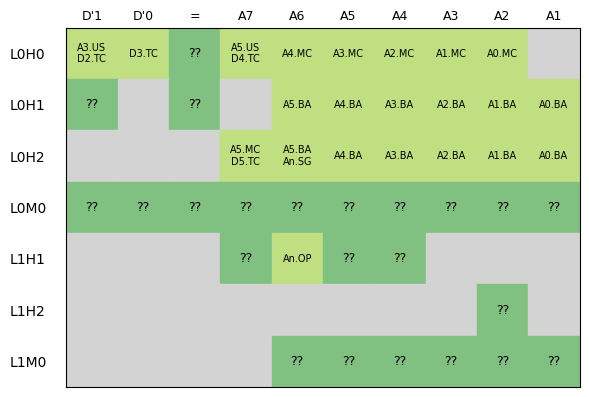

In [139]:
show_quanta_map( "Algorithm Purpose Per Node", False, 2, None, QuantaType.ALGO, "", get_quanta_binary, 9)

# Part 23: Save useful nodes with behaviour and algorithm tags to JSON file

Show a list of the nodes that have proved useful in calculations, together with data on the nodes behavior and algorithmic purposes.
Save the data to a Colab temporary JSON file.



In [140]:
cfg.useful_nodes.print_node_tags(QuantaType.ALGO, "", False)

P11L0H0 ['A3.US', 'D2.TC']
P12L0H0 ['D3.TC']
P14L0H0 ['A5.US', 'D4.TC']
P14L0H2 ['A5.MC', 'D5.TC']
P15L0H0 ['A4.MC']
P15L0H1 ['A5.BA']
P15L0H2 ['A5.BA', 'An.SG']
P15L1H1 ['An.OP']
P16L0H0 ['A3.MC']
P16L0H1 ['A4.BA']
P16L0H2 ['A4.BA']
P17L0H0 ['A2.MC']
P17L0H1 ['A3.BA']
P17L0H2 ['A3.BA']
P18L0H0 ['A1.MC']
P18L0H1 ['A2.BA']
P18L0H2 ['A2.BA']
P19L0H0 ['A0.MC']
P19L0H1 ['A1.BA']
P19L0H2 ['A1.BA']
P20L0H1 ['A0.BA']
P20L0H2 ['A0.BA']


In [141]:
# Serialize and save the useful nodes list with algorithm tags to a temporary CoLab file in JSON format
print( "Saving useful node list with algorithm tags:", main_fname_algorithm_json)
cfg.useful_nodes.save_nodes(main_fname_algorithm_json)

Saving useful node list with algorithm tags: add_d6_l2_h3_t15K_s372001_algorithm.json


# Part 25B: Results: Test Algorithm - Addition

## Part25B.1 Model add_d5_l1_h3_t30K. Tasks An.BA, An.MC, An.US

This 1-layer model cant do all addition questions. This hypothesis mirrors Paper 1. 14/15 heads have purpose assigned. 0/6 neurons have purpose assigned.

In [142]:
# For answer digits (excluding Amax), An.BA and An.MC nodes are needed before the answer digit is revealed
def test_algo_ba_mc(algo_nodes):
  for impact_digit in range(cfg.n_digits):
    cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(add_ba_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))

    cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(add_mc_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))


# For answer digits (excluding Amax), An.US nodes are needed before the answer digit is revealed
def test_algo_us(algo_nodes):
  for impact_digit in range(cfg.n_digits):
      cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(add_us_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))

In [143]:
if cfg.model_name == "add_d5_l1_h3_t30K":

  algo_nodes = cfg.start_algorithm_test(acfg)

  test_algo_ba_mc(algo_nodes)
  test_algo_us(algo_nodes)
  cfg.print_algo_clause_results()

  cfg.print_algo_purpose_results(algo_nodes)

## Part25B.2 Models add_d5/d6_l2_h3_t15K. Tasks An.BA, An.MC, An.US, Dn.C

These 2-layer models can do addition accurately. This hypothesis mirrors Paper 2.

In [144]:
# Before Amax is revealed (as a 0 or 1), there must be a Dn.C node for every digit pair
# For each digit (except A0) there must be either an An.US or an Dn.C
def test_algo_tc_us(model_nodes):
  for impact_digit in range(cfg.n_digits):
    early_dnc = FilterAnd(FilterAlgo(add_tc_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(cfg.n_digits+1), QuantaFilter.MUST_BY))
    late_dnc = FilterAnd(FilterAlgo(add_tc_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY))
    any_dnus = FilterAnd(FilterAlgo(add_us_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY))

    if cfg.n_layers == 1:
      # There must be a Dn.US node for every answer digit except A0
      if impact_digit > 0:
        cfg.test_algo_clause(model_nodes, any_dnus)
    else:
      # There must be a Dn.US node or a Dn.C node for every digit except A0
      if impact_digit > 0:
        cfg.test_algo_clause(model_nodes, FilterOr(any_dnus, late_dnc))

      # There must a Dn.C node for every digit before the first 1 or 0 digit is calculated
      cfg.test_algo_clause(model_nodes, early_dnc)

In [145]:
if cfg.model_name == "add_d5_l2_h3_t15K" or cfg.model_name == "add_d6_l2_h3_t15K":

  algo_nodes = cfg.start_algorithm_test(acfg)

  test_algo_ba_mc(algo_nodes)
  test_algo_tc_us(algo_nodes)
  cfg.print_algo_clause_results()

  cfg.print_algo_purpose_results(algo_nodes)

Varied_questions prediction success rate = 20.00% (128 good, 512 bad)

Clause valid: P20L0H1, P20L0H2  match  and( must Algorithm A0.BA, must-by P20)
Clause invalid: No nodes match  and( must Algorithm A-1.MC, must-by P20)
Clause valid: P19L0H1, P19L0H2  match  and( must Algorithm A1.BA, must-by P19)
Clause valid: P19L0H0  match  and( must Algorithm A0.MC, must-by P19)
Clause valid: P18L0H1, P18L0H2  match  and( must Algorithm A2.BA, must-by P18)
Clause valid: P18L0H0  match  and( must Algorithm A1.MC, must-by P18)
Clause valid: P17L0H1, P17L0H2  match  and( must Algorithm A3.BA, must-by P17)
Clause valid: P17L0H0  match  and( must Algorithm A2.MC, must-by P17)
Clause valid: P16L0H1, P16L0H2  match  and( must Algorithm A4.BA, must-by P16)
Clause valid: P16L0H0  match  and( must Algorithm A3.MC, must-by P16)
Clause valid: P15L0H1, P15L0H2  match  and( must Algorithm A5.BA, must-by P15)
Clause valid: P15L0H0  match  and( must Algorithm A4.MC, must-by P15)
Clause invalid: No nodes match  

# Part 25C: Results: Test Algorithm - Subtraction

## Part 2C.1: Model XXX. Tasks BS, BO, SZ

This 2-layer model can do subtraction accurately. TBC

In [146]:
# For answer digits (excluding Amax), An.BS and An.BO nodes are needed before the answer digit is revealed
def test_algo_bs_bo(algo_nodes):
  for impact_digit in range(cfg.n_digits):
    cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(sub_bs_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))

    cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(sub_bo_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))


# For answer digits (excluding Amax), An.SZ nodes are needed before the answer digit is revealed
def test_algo_sz(algo_nodes):
  for impact_digit in range(cfg.n_digits):
      pass
      #cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(sub_sz_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit+1), QuantaFilter.MUST_BY)))

In [147]:
if cfg.model_name == "sub_d6_l2_h3_t30K":

  algo_nodes = cfg.start_algorithm_test(acfg)

  test_algo_bs_bo(algo_nodes)
  test_algo_sz(algo_nodes)
  cfg.print_algo_clause_results()

  cfg.print_algo_purpose_results(algo_nodes)

## Part 2C.2: Test Algorithm - Subtraction - Negative Answer

We claim the model converts subtraction questions D - D' to the mathematically equivalent - ( D' - D ) when D' > D. To do this the model needs to know when D' > D (or equivalently when D' > D).

To calculate D'>D, model needs to calculate D'6>D6 else D'5>D5 else D'4>D4 else D'3>D3 else D'2>D2 else D'1>D1 else D'1>D1. We expect to see nodes only used in NG questions, with PCA bigram (or trigram) outputs, attending to these input pairs, evaluated in this order.


In [148]:
# For answer digits (excluding Amax), An.NG is needed before the answer digit is revealed
def test_algo_ng(algo_nodes):
  ng_locations = {}

  for impact_digit in range(cfg.n_digits):
    # For answer digits (excluding the +/- sign and 0 or 1 Amax), An.NG is calculated before the answer digit is revealed
    position = cfg.test_algo_clause(algo_nodes, FilterAnd(FilterAlgo(sub_ng_tag(impact_digit)), FilterPosition(cfg.an_to_position_name(impact_digit), QuantaFilter.MUST_BY)))
    ng_locations[impact_digit] = position

  # Check that ng_locations[6] < ng_locations[5] < ng_locations[4] < etc
  for impact_digit in range(cfg.n_digits):
    if impact_digit > 0:
      cfg.test_algo_logic("NG Ordering for A" + str(impact_digit), ng_locations[impact_digit] < ng_locations[impact_digit-1])

In [149]:
if cfg.model_name == "sub_d6_l2_h3_t30K":

  algo_nodes = cfg.start_algorithm_test(acfg)

  test_algo_ng(algo_nodes)
  cfg.print_algo_clause_results()

  cfg.print_algo_purpose_results(algo_nodes)

# Part 26: Test Algorithm - Mixed Addition and Subtraction model

Our working assumption for models ins1_mix_d6_l3_h4_t40K, ins2_mix_d6_l4_h4_t40K and ins3_mix_d6_l4_h3_t40K is that the model's algorithm is:

* H1: Pays attention to the +\- question operator (using OP task)
* If operator is "+" then  
  * H2: Does addition using BA, MC, US & TC tasks
* Else
  * H3: Calculates whether D > D' (using NG tasks)
  * If D > D' then
    * H4: Amax is "+"
    * H4: Does subtraction using BS, BO, SZ & T?? tasks
  * Else
    * H5: Amax is =-"
    * H6: Applys D - D' = - (D' - D) transform
    * H4: Does subtraction using BS, BO, SZ & T?? tasks
    * H6: Applys D - D' = - (D' - D) transform a second time

Each of the algorithm sub-tasks H1 to H6 will be validated separately.

TBC: H6 seems unlikely. Can it be done as one step?












In [150]:
mixed_model = cfg.model_name == "ins1_mix_d6_l3_h4_t40K" or cfg.model_name == "ins2_mix_d6_l4_h4_t40K" or cfg.model_name == "ins3_mix_d6_l4_h3_t40K"

## Part 26.H3 Calculate whether D > D' (using NG tasks)

In [151]:
# Only display nodes with the SUB_NG_TAG tag.
filters = FilterContains(QuantaType.MATH_SUB, MathsBehavior.SUB_NG_TAG)

show_quanta_map( "Subtraction Behavior NG Nodes", False, 2, filters, QuantaType.MATH_SUB, "", get_maths_min_complexity)
show_quanta_map( "Attention Behavior Per (NG) Head", True, 10, filters, QuantaType.ATTENTION, "", get_quanta_attention, 10, 6)
show_quanta_map( "Algorithm Purpose Per (NG) Node", False, 2, filters, QuantaType.ALGO, "", get_quanta_binary, 9, 10)

print("NG tagged nodes:", filter_nodes( cfg.useful_nodes, filters ).get_node_names())

Saving quanta map: Subtraction Behavior NG Nodes


Saving quanta map: Attention Behavior Per (NG) Head


Saving quanta map: Algorithm Purpose Per (NG) Node


NG tagged nodes: 


In [152]:
if mixed_model:
  algo_nodes = cfg.start_algorithm_test(acfg)

  test_algo_ng(algo_nodes)
  cfg.print_algo_clause_results()

  cfg.print_algo_purpose_results(algo_nodes)

# Part 30: Unit Test automated searches

In [153]:
def unit_test_node_tag(node_location_as_str, the_tags ):
  node_location = str_to_node_location(node_location_as_str)
  node = cfg.useful_nodes.get_node(node_location)
  assert node is not None

  for the_tag in the_tags:
    if not node.contains_tag( QuantaType.ALGO, the_tag):
      print( "Unit test failure: Node", node.name(), "does not have expected tag", the_tag)

In [154]:
print(cfg.model_name)

if cfg.model_name == 'add_d6_l2_h3_t15K':
  unit_test_node_tag('P11L0H0', ['D2.TC'] )
  unit_test_node_tag('P12L0H0', ['D3.TC'] )
  unit_test_node_tag('P14L0H0', ['A5.US', 'D4.TC'] )
  unit_test_node_tag('P14L0H2', ['A5.MC', 'D5.TC'] )
  unit_test_node_tag('P14L1H1', ['OP'] )
  unit_test_node_tag('P15L0H0', ['A4.MC'] )
  unit_test_node_tag('P15L0H1', ['A5.BA'] )
  unit_test_node_tag('P15L0H2', ['A5.BA'] )
  unit_test_node_tag('P16L0H0', ['A3.MC'] )
  unit_test_node_tag('P16L0H1', ['A4.BA'] )
  unit_test_node_tag('P16L0H2', ['A4.BA'] )
  unit_test_node_tag('P17L0H0', ['A2.MC'] )
  unit_test_node_tag('P17L0H1', ['A3.BA'] )
  unit_test_node_tag('P17L0H2', ['A3.BA'] )
  unit_test_node_tag('P18L0H0', ['A1.MC'] )
  unit_test_node_tag('P18L0H1', ['A2.BA'] )
  unit_test_node_tag('P18L0H2', ['A2.BA'] )
  unit_test_node_tag('P19L0H0', ['A0.MC'] )
  unit_test_node_tag('P19L0H1', ['A1.BA'] )
  unit_test_node_tag('P19L0H2', ['A1.BA'] )
  unit_test_node_tag('P20L0H1', ['A0.BA'] )
  unit_test_node_tag('P20L0H2', ['A0.BA'] )

if cfg.model_name == 'mix_d6_l3_h4_t40K':
  unit_test_node_tag('P8L0H1', ['OP'] )
  unit_test_node_tag('P13L2H0', ['A7.NG'] )
  unit_test_node_tag('P15L0H0', ['A5.BA', 'A5.BS'] )
  unit_test_node_tag('P15L0H3', ['A5.BA', 'A5.BS'] )
  unit_test_node_tag('P16L0H3', ['A4.BA.A4', 'A4.BS.A4'] )
  unit_test_node_tag('P17L0H1', ['A3.NG'] )
  unit_test_node_tag('P17L0H3', ['A3.BA.A3', 'A3.BS.A3'] )
  unit_test_node_tag('P18L0H1', ['A2.NG'] )
  unit_test_node_tag('P18L0H3', ['A2.BA.A2', 'A2.BS.A2'] )
  unit_test_node_tag('P19L0H1', ['A1.NG'] )
  unit_test_node_tag('P19L0H3', ['A1.BA.A1', 'A1.BS.A1'] )
  unit_test_node_tag('P20L0H0', ['A0.BA', 'A0.BS'] )
  unit_test_node_tag('P20L0H3', ['A0.BA', 'A0.BS'] )
  unit_test_node_tag('P20L2H1', ['A0.NG'] )

if cfg.model_name == 'ins1_mix_d6_l3_h4_t40K':
  unit_test_node_tag('P9L0H1', ['D4.TC'] )
  unit_test_node_tag('P9L0H3', ['A5.NG', 'OP'] )
  unit_test_node_tag('P10L0H1', ['D2.TC'] )
  unit_test_node_tag('P12L0H1', ['D3.TC'] )
  unit_test_node_tag('P13L2H0', ['A7.NG'] )
  unit_test_node_tag('P14L0H0', ['A5.US', 'A6.NG'] )
  unit_test_node_tag('P14L0H2', ['A5.MC', 'D5.TC'] )
  unit_test_node_tag('P15L0H0', ['A4.MC'] )
  unit_test_node_tag('P15L0H1', ['A5.BA', 'A5.BS'] )
  unit_test_node_tag('P15L0H2', ['A5.BA', 'A5.BS'] )
  unit_test_node_tag('P16L0H0', ['A3.MC'] )
  unit_test_node_tag('P16L0H1', ['A4.BA', 'A4.BS'] )
  unit_test_node_tag('P16L0H2', ['A4.BA', 'A4.BS'] )
  unit_test_node_tag('P16L2H0', ['A4.NG'] )
  unit_test_node_tag('P17L0H0', ['A2.MC'] )
  unit_test_node_tag('P17L0H1', ['A3.BA', 'A3.BS'] )
  unit_test_node_tag('P17L0H2', ['A3.BA', 'A3.BS'] )
  unit_test_node_tag('P17L2H0', ['A3.NG'] )
  unit_test_node_tag('P18L0H0', ['A1.MC'] )
  unit_test_node_tag('P18L0H1', ['A2.BA', 'A2.BS'] )
  unit_test_node_tag('P18L0H2', ['A2.BA', 'A2.BS'] )
  unit_test_node_tag('P18L2H0', ['A2.NG'] )
  unit_test_node_tag('P19L0H0', ['A0.MC'] )
  unit_test_node_tag('P19L0H1', ['A1.BA', 'A1.BS'] )
  unit_test_node_tag('P19L0H2', ['A1.BA', 'A1.BS'] )
  unit_test_node_tag('P19L2H0', ['A1.NG'] )
  unit_test_node_tag('P20L0H0', ['A0.NG'] )
  unit_test_node_tag('P20L0H1', ['A0.BA', 'A0.BS'] )
  unit_test_node_tag('P20L0H2', ['A0.BA', 'A0.BS'] )

add_d6_l2_h3_t15K
Unit test failure: Node P14L1H1 does not have expected tag OP
